# Logistic Growth (Verhulst) - Modelling of COVID-19 (in the Netherlands)

**Authors:** J.H. Cao 
<br>
**Supervisors:** prof.dr.ir. N.A.W. van Riel, dr. D. Bosnacki
<br>
**Deparment:** Biomedical Engineering, Computational Biology Group at Eindhoven University of Technology

This notebook contain the codes to model and simulate an epidemic. The focus is on **a logistic growth model developed by Verhulst** and can be used for  the mathematical modelling of an infectious disease.



More specifically, the model will be used to model the spread of **COVID-19** in the Netherlands. Furhtermore, with the this model, it a possible to get an estimation of the number of people infected with COVID-19 ( _this is an estimate, the true number can only be verified with testing_ ). 

There are two approaches for the logistic growth function, which are:
<br>
1. Using the package from Scipy, to perform a curve fitting and return the optimal parameters for the logistic growth. This package uses **"Nonlinear Least Squares Estimation"**.
<br>
2. Using a self-defined function, to estimate the parameters (for the logistic funtion), based on **"Maximum Likelihood Estimation"**.

<br>
With these models, it is also possible to analyse whether a "lockdown" has any effect on the course/spread of this virus.


## Imports

### Packages

This section is for the import of the important python packages needed to develop these models.

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit # This package is necessary for the logistic growth curve fit 

### Data - Number of recorded cases in the Netherlands

This section is for the import of the data regarding the number of recorded cases of COVID-19 in the Netherlands

In [2]:
# The newest file containing the number of (+) cases in the Netherlands

covid19_NL_file = './data/rivm_corona_in_nl_daily.txt'

df_covid =  pd.read_csv(covid19_NL_file, parse_dates=['Datum']).set_index("Datum")

df_covid.head()

,Aantal
Datum,
2020-02-27,1
2020-02-28,2
2020-02-29,7
2020-03-01,10
2020-03-02,18


### Data - Number of Hospital Admission / ICU in the Netherlands ( under development)

#### Hospital intake:

In [3]:
hosp_NL_intake = './data/rivm_corona_in_nl_hosp.csv'

df_hosp_nl = pd.read_csv(hosp_NL_intake, parse_dates=['Datum']).set_index("Datum")
df_hosp_nl.iloc[15:20]

,Hospital Intake
Datum,
2020-03-13,115
2020-03-14,136
2020-03-15,162
2020-03-16,205
2020-03-17,314


#### ICU intake:

In [4]:
icu_NL_intake = './data/icu_opname.csv'
df_icu_nl = pd.read_csv(icu_NL_intake, parse_dates=['Datum']).set_index("Datum")
df_icu_nl.head()

,IC Admission
Datum,
2020-02-27,6
2020-02-28,7
2020-02-29,8
2020-03-01,10
2020-03-02,9


<br>

## Logistic Growth (3 parameters, Verhulst) - Number of Recorded Cases

### Nonlinear Least Squares Estimation

In [5]:
# Adding a column of timestep for the curve_fit to the dataframe

df_covid['Timestep'] = [timestep for timestep in range(0, len(df_covid))]


# Re-arrange the columns 

cols = df_covid.columns.to_list()
cols = cols[1:] + cols[:-1]

df_covid = df_covid[cols]
df_covid.head()

,Timestep,Aantal
Datum,,
2020-02-27,0,1
2020-02-28,1,2
2020-02-29,2,7
2020-03-01,3,10
2020-03-02,4,18


In [6]:
# Changing the column name from dutch to english

df_covid = df_covid.rename(columns={"Aantal":"Total Cases"})
df_covid.head()

,Timestep,Total Cases
Datum,,
2020-02-27,0,1
2020-02-28,1,2
2020-02-29,2,7
2020-03-01,3,10
2020-03-02,4,18


In [37]:
df_covid['New Cases'] = df_covid[['Total Cases']].diff()
df_covid['New Cases'].iloc[0] = 0
df_covid.head()

,Timestep,Total Cases,New Cases
Datum,,,
2020-02-27,0,1,0.0
2020-02-28,1,2,1.0
2020-02-29,2,7,5.0
2020-03-01,3,10,3.0
2020-03-02,4,18,8.0


In [8]:
# Defining the logistic growth function with 3 parameters (Verhulst) for the population growth

# a = alpha (number of days at which the expected numer of cases is half the maximum)
# b = Beta (growth paramter / factor)
# c = M (expected maximum)
# t = time in days 

def logistic_growth(t, a, b, c):
    E = c / (1 + np.exp(-b * (t - a)))
    return E
    
# Obtaining the x and y data

x = np.array(df_covid['Timestep'])
y = np.array(df_covid['Total Cases'])

# Random initiazation of parameters and upper bound limit 

p0 = np.random.exponential(size = 3)

bounds = (0, [10000, 3, 17000000]) # upper bounds for the given parameters (alpha, beta, M)

In [9]:
# Fitting the logistic growth fucntion and defining the prediction function

(alpha, beta, M), logistic_cov = curve_fit(logistic_growth, x, y, bounds=bounds, p0=p0)

def logistic_pred(t):
    E = M / (1 + np.exp(-beta * (t - alpha)))
    return E

#### The estimated parameters and statistics:

In [10]:
def r_squared_logistic():
    residuals = y - logistic_pred(x)
    ss_res = np.sum(residuals**2)

    ss_tot = np.sum((y - np.mean(y))**2)

    R_squared = 1 - (ss_res / ss_tot)
    
    return R_squared

In [11]:
def prt_results_logistic():
    logistic_line = '%5s  %16s  %15s' % ("alpha = ", "beta = ", "M = ")
    logistic_params = '%5s  %14s  %14s' % (alpha, beta, M)

    print("**The estimated logistic growth parameters are:**")
    print()
    print(logistic_line)
    print(logistic_params)

    print()
    
    r2line = "%5s" % ("R^2 = ")
    r2_val = "%12s" % (r_squared_logistic())
    
    print("**The R^2 value for this logistic growth model is:**")
    print()
    print(r2line)
    print(r2_val)
    print()

#### Plotting the results:

In [12]:
max_cases = []

for i in x:
    max_cases.append(M)
predicted_max = np.array(max_cases)

**The estimated logistic growth parameters are:**

alpha =            beta =              M = 
40.685686296408086  0.12243981789623797  41114.01795195482

**The R^2 value for this logistic growth model is:**

R^2 = 
0.9975544953327031



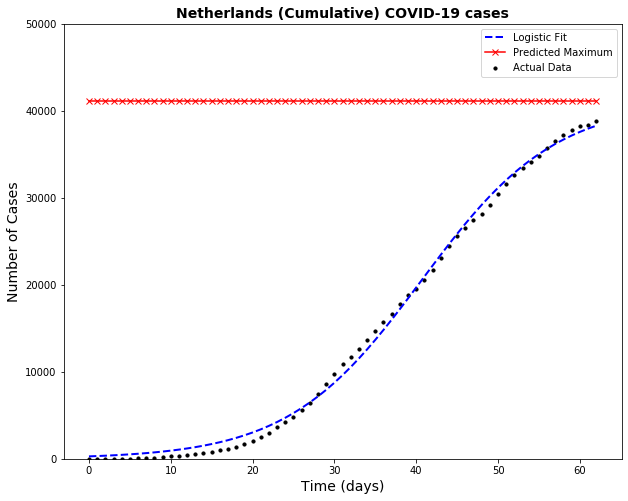

In [13]:
plt.figure(figsize=(10,8))

plt.scatter(x, y, s=10, marker='o', c='k')
plt.plot(x, logistic_pred(x), '--', lw=2, c='blue')
plt.plot(x, predicted_max, '-x', c='r')
plt.legend(['Logistic Fit', 'Predicted Maximum', 'Actual Data' ])
plt.ylim([0, 50000])

plt.title("Netherlands (Cumulative) COVID-19 cases", Fontsize = 14, weight='bold')
plt.xlabel("Time (days)", Fontsize = 14)
plt.ylabel("Number of Cases", Fontsize = 14);



prt_results_logistic() # Uncomment for statistics

### Maxmimum Likelihood Estimation

In [14]:
# from scipy.optimize import minimize

# def lik(parameters):
#     c_mle = parameters[0]
#     b_mle = parameters[1]
#     a_mle = parameters[2]
#     sigma_mle = parameters[3]
    
#     for i in np.arange(0, len(x)):
#         y_exp = c_mle / (1 + np.exp(-b_mle * (x - a_mle)))
    
#     L = (len(x)/2 * np.log(2 * np.pi) + len(x)/2 * np.log(sigma_mle ** 2) + 1 /
#          (2 * sigma_mle ** 2) * sum((y - y_exp) ** 2))
#     return L


# lik_model = minimize(lik, np.array([1,1,1,1]), method='L-BFGS-B')
# c_mle = lik_model['x'][0]
# b_mle = lik_model['x'][1]
# a_mle = lik_model['x'][2]

# y_exp = c_mle / (1 + np.exp(-b_mle * (x - a_mle)))
# plt.scatter(x,y)
# plt.plot(x, y_exp)
# plt.show()


In [15]:
# def y_exp(t):
#     return c_mle / (1 + np.exp(-b_mle * (t - a_mle)))


In [16]:
# y_exp

## Logistic Growth (3 parameters, Verhulst) - Hospital & ICU admission

### Hospital admission

In [17]:
df_hosp_nl['Timestep'] = [timestep for timestep in range(0, len(df_hosp_nl))]  # Creating a timestep for each day

# Re-arrange the columns 

cols_hosp = df_hosp_nl.columns.to_list()
cols_hosp = cols_hosp[1:] + cols_hosp[:-1]

df_hosp_nl = df_hosp_nl[cols_hosp]


In [18]:
df_hosp_nl['New Admissions'] = df_hosp_nl[['Hospital Intake']].diff()
df_hosp_nl['New Admissions'].iloc[0] = 0
df_hosp_nl.head()

,Timestep,Hospital Intake,New Admissions
Datum,,,
2020-02-27,0,0,0.0
2020-02-28,1,0,0.0
2020-02-29,2,0,0.0
2020-03-01,3,0,0.0
2020-03-02,4,0,0.0


In [19]:
# Defining the logistic growth function with 3 parameters (Verhulst) for the population growth

# a = alpha (number of days at which the expected numer of cases is half the maximum)
# b = Beta (growth paramter / factor)
# c = M (expected maximum)
# t = time in days 

def logistic_growth_hosp(t, a, b, c):
    E = c / (1 + np.exp(-b * (t - a)))
    return E
    
# Obtaining the x and y data

x_hosp = np.array(df_hosp_nl['Timestep'])
y_hosp = np.array(df_hosp_nl['Hospital Intake'])

# Random initiazation of parameters and upper bound limit 

p0_hosp = np.random.exponential(size = 3)

bounds_hosp = (0, [10000, 3, 20000]) # upper bounds for the given parameters (alpha, beta, M)

In [20]:
# Fitting the logistic growth fucntion and defining the prediction function

(alpha_hosp, beta_hosp, M_hosp), lhosp_cov = curve_fit(logistic_growth_hosp, x_hosp, y_hosp, bounds=bounds_hosp, p0=p0_hosp)

def logistic_pred_hosp(t):
    E = M_hosp / (1 + np.exp(-beta_hosp * (t - alpha_hosp)))
    return E

#### The estimated parameters and statistics:


In [21]:
def r_squared_logistic_hosp():
    residuals = y_hosp - logistic_pred_hosp(x_hosp)
    ss_res = np.sum(residuals**2)

    ss_tot = np.sum((y_hosp - np.mean(y_hosp))**2)

    R_squared = 1 - (ss_res / ss_tot)
    
    return R_squared

In [22]:
def prt_results_logistic_hosp():
    logistic_line = '%5s  %16s  %15s' % ("alpha_hosp = ", "beta_hosp = ", "M_hosp = ")
    logistic_params = '%5s  %14s  %14s' % (alpha_hosp, beta_hosp, M_hosp)

    print("**The estimated logistic growth parameters are:**")
    print()
    print(logistic_line)
    print(logistic_params)

    print()
    
    r2line = "%5s" % ("R^2 = ")
    r2_val = "%12s" % (r_squared_logistic_hosp())
    
    print("**The R^2 value for this logistic growth model is:**")
    print()
    print(r2line)
    print(r2_val)
    print()

#### Plotting the results:

In [23]:
max_hosp = []

for i in x_hosp:
    max_hosp.append(M_hosp)
predicted_max_hosp = np.array(max_hosp)

**The estimated logistic growth parameters are:**

alpha_hosp =       beta_hosp =         M_hosp = 
34.58560079721767  0.18941183802786304  10213.480308073247

**The R^2 value for this logistic growth model is:**

R^2 = 
0.9968010247686316



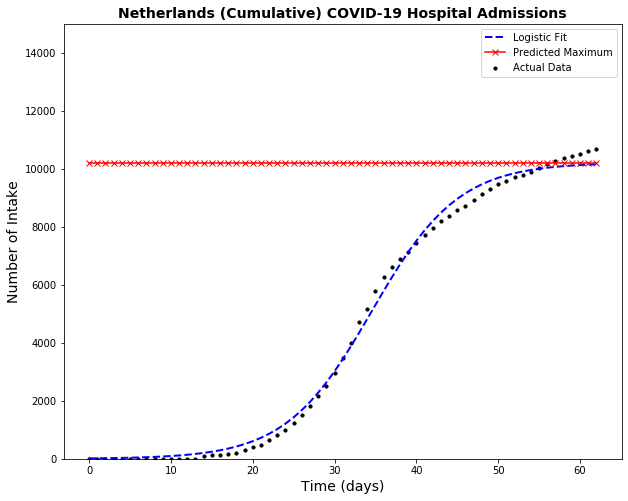

In [24]:
plt.figure(figsize=(10,8))

plt.scatter(x_hosp, y_hosp, s=10, marker='o', c='k')
plt.plot(x_hosp, logistic_pred_hosp(x_hosp), '--', lw=2, c='blue')
plt.plot(x_hosp, predicted_max_hosp, '-x', c='r')
plt.legend(['Logistic Fit', 'Predicted Maximum', 'Actual Data' ])
plt.ylim([0, 15000])

plt.title("Netherlands (Cumulative) COVID-19 Hospital Admissions", Fontsize = 14, weight='bold')
plt.xlabel("Time (days)", Fontsize = 14)
plt.ylabel("Number of Intake", Fontsize = 14);


prt_results_logistic_hosp() # Uncomment for statistics

### ICU admission

In [25]:
df_icu_nl['Timestep'] = [timestep for timestep in range(0, len(df_icu_nl))]  # Creating a timestep for each day

# Re-arrange the columns 

cols_icu = df_icu_nl.columns.to_list()
cols_icu = cols_icu[1:] + cols_icu[:-1]

df_icu_nl = df_icu_nl[cols_icu]


In [26]:
df_icu_nl['New Admissions'] = df_icu_nl[['IC Admission']].diff()
df_icu_nl['New Admissions'].iloc[0] = 0
df_icu_nl.head()

,Timestep,IC Admission,New Admissions
Datum,,,
2020-02-27,0,6,0.0
2020-02-28,1,7,1.0
2020-02-29,2,8,1.0
2020-03-01,3,10,2.0
2020-03-02,4,9,-1.0


In [27]:
# Defining the logistic growth function with 3 parameters (Verhulst) for the population growth

# a = alpha (number of days at which the expected numer of cases is half the maximum)
# b = Beta (growth paramter / factor)
# c = M (expected maximum)
# t = time in days 

def logistic_growth_icu(t, a, b, c):
    E = c / (1 + np.exp(-b * (t - a)))
    return E
    
# Obtaining the x and y data

x_icu = np.array(df_icu_nl['Timestep'])
y_icu = np.array(df_icu_nl['IC Admission'])

# Random initiazation of parameters and upper bound limit 

p0_icu = np.random.exponential(size = 3)

bounds_icu = (0, [10000, 3, 2000]) # upper bounds for the given parameters (alpha, beta, M)

In [28]:
# Fitting the logistic growth fucntion and defining the prediction function

(alpha_icu, beta_icu, M_icu), licu_cov = curve_fit(logistic_growth_icu, x_icu, y_icu, bounds=bounds_icu, p0=p0_icu)

def logistic_pred_icu(t):
    E = M_icu / (1 + np.exp(-beta_icu * (t - alpha_icu)))
    return E

#### The estimated parameters and statistics:

In [29]:
def r_squared_logistic_icu():
    residuals = y_icu - logistic_pred_icu(x_icu)
    ss_res = np.sum(residuals**2)

    ss_tot = np.sum((y_icu - np.mean(y_icu))**2)

    R_squared = 1 - (ss_res / ss_tot)
    
    return R_squared

In [30]:
def prt_results_logistic_icu():
    logistic_line = '%5s  %16s  %15s' % ("alpha_icu = ", "beta_icu = ", "M_icu = ")
    logistic_params = '%5s  %14s  %14s' % (alpha_icu, beta_icu, M_icu)

    print("**The estimated logistic growth parameters are:**")
    print()
    print(logistic_line)
    print(logistic_params)

    print()
    
    r2line = "%5s" % ("R^2 = ")
    r2_val = "%12s" % (r_squared_logistic_icu())
    
    print("**The R^2 value for this logistic growth model is:**")
    print()
    print(r2line)
    print(r2_val)
    print()

#### Plotting the results

In [31]:
max_icu = []

for i in x_icu:
    max_icu.append(M_icu)
predicted_max_icu = np.array(max_icu)

**The estimated logistic growth parameters are:**

alpha_icu =        beta_icu =          M_icu = 
24.373715487258714  0.35709506836475263  1126.5213357518069

**The R^2 value for this logistic growth model is:**

R^2 = 
0.938207951083088



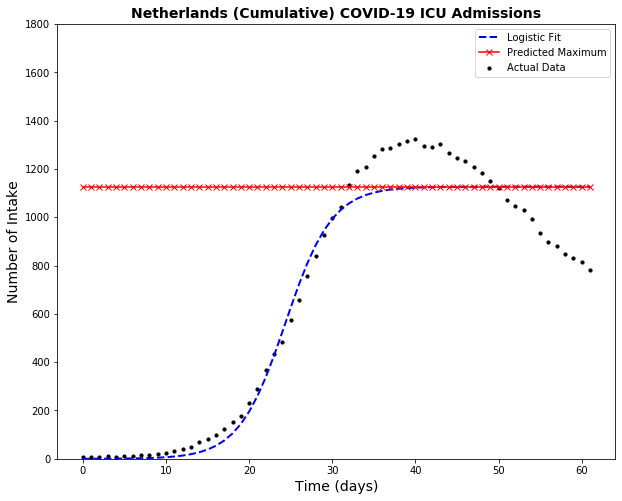

In [32]:
plt.figure(figsize=(10,8))

plt.scatter(x_icu, y_icu, s=10, marker='o', c='k')
plt.plot(x_icu, logistic_pred_icu(x_icu), '--', lw=2, c='blue')
plt.plot(x_icu, predicted_max_icu, '-x', c='r')
plt.legend(['Logistic Fit', 'Predicted Maximum', 'Actual Data' ])
plt.ylim([0, 1800])

plt.title("Netherlands (Cumulative) COVID-19 ICU Admissions", Fontsize = 14, weight='bold')
plt.xlabel("Time (days)", Fontsize = 14)
plt.ylabel("Number of Intake", Fontsize = 14);


prt_results_logistic_icu() # Uncomment for statistics

## Exponential Growth (3 parameters) - Trajectory for Number of Recorded Cases

### Fitting curve for current trajectory

In [33]:
def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

p0_exp = np.random.exponential(size = 3)

bounds_exp = (0, [1000, 3, 17000000]) # upper bounds for the given parameters (a, b, c)

(a, b, c), exp_cov = curve_fit(exponential, x, y, bounds=bounds_exp, p0=p0_exp)

def exp_pred(t):
    return a * np.exp(b * t) + c

### The estimated parameters and statistics:

In [34]:
def r_squared_exp():
    residuals = y - exp_pred(x)
    ss_res = np.sum(residuals**2)

    ss_tot = np.sum((y - np.mean(y))**2)

    R_squared = 1 - (ss_res / ss_tot)
    
    return R_squared

In [35]:
def prt_results_exp():
    exp_line = '%4s  %18s  %18s' % ("a = ", "b = ", "c = ")
    exp_params = '%5s  %14s  %14s' % (a, b, c)

    print("**The estimated exponential growth parameters are:**")
    print()
    print(exp_line)
    print(exp_params)

    print()
    
    r2line = "%5s" % ("R^2 = ")
    r2_val = "%12s" % (r_squared_exp())
    
    print("**The R^2 value for this exponential growth model is:**")
    print()
    print(r2line)
    print(r2_val)
    print()
    print("**A downward deviation from the blue line (predicted trajectory)")
    print(", means that there is potential decrease in the spread of COVID-19 **")

### Plot Trajectory (Log scale):

**The estimated exponential growth parameters are:**

a =                 b =                 c = 
999.9999999999558  0.06245673812176711  2015.69325980029

**The R^2 value for this exponential growth model is:**

R^2 = 
0.8986886317305279

**A downward deviation from the blue line (predicted trajectory)
, means that there is potential decrease in the spread of COVID-19 **


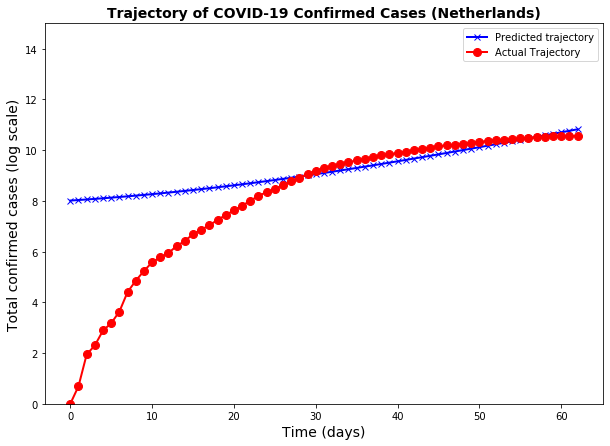

In [36]:
plt.figure(figsize=(10,7))


plt.plot(x, np.log(exp_pred(x)),'-x',lw=2, c='blue')
plt.plot(x, np.log(y),'-o',lw=2, c='red', ms=8)


plt.legend(['Predicted trajectory', 'Actual Trajectory'])
plt.ylim([0, 15])

# arrow = {'facecolor':'black', 'width':2, 'shrink':0.05}
# plt.annotate("TDQ announced", xy=(8, 2.0 ), xytext=(8, 0.5), arrowprops=arrow)
# plt.annotate("Effect taking place", xy=(15, 3.5 ), xytext=(15, 2.0 ), arrowprops=arrow)

plt.title("Trajectory of COVID-19 Confirmed Cases (Netherlands)", Fontsize = 14, weight='bold')
plt.xlabel("Time (days)", Fontsize = 14)
plt.ylabel("Total confirmed cases (log scale)", Fontsize = 14);



prt_results_exp()  # Uncomment for statistics 